In [1]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
import pandas_datareader as pdr 
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from statsmodels.tsa.statespace.varmax import VARMAX
import math

In [2]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    def wape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.sum(np.abs((y_true - y_pred)))/np.sum(np.abs(y_true))) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'WAPE is : {wape(y_true, y_pred)}')
    #print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    #print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [3]:
def ccc_cov(var, cor):
    cov = np.diag(var)
    cov_01 = cor[0]*np.sqrt(var[0])*np.sqrt(var[1])
    cov_02 = cor[1]*np.sqrt(var[0])*np.sqrt(var[2])
    cov_12 = cor[2]*np.sqrt(var[1])*np.sqrt(var[2])
    cov[0,1] = cov[1, 0] = cov_01
    cov[0,2] = cov[2, 0] = cov_02
    cov[1,2] = cov[2, 1] = cov_12
    return cov

In [4]:
def rev(df):
    ans = []
    for i in range(df.size-1):
        ans.append(math.log(df[i+1]/df[i]))
    return pd.Series(ans, index = df.index[:-1])

def get_data(names, st, en):
    data = [] 
    for i in names:
        data.append(100*rev(pdr.get_data_yahoo(str(i), start=st, end=en).Close).rename(str(i)))
    return data
def get_prices(names, st, en):
    data = [] 
    for i in names:
        data.append(pdr.get_data_yahoo(str(i), start=st, end=en).Close.rename(str(i)))
    return data

def calc_var(profits, alpha):
    return np.quantile(profits, 1 - alpha)

def portf_mean(w, mean):
    mu = np.array(mean)
    W = np.array(w)
    return np.dot(mu, W)

def portf_variance(w, covariance):
    W = np.array(w)
    return W.T@np.array(covariance)@W

def portfolio_search(vec_mean, vec_cov, mean_level=0):
    decided_mean_portf = [10]*3
    min_var_portf = [10]*3
    t = np.linspace(0, 1, 101)
    vec_p_var = []
    vec_p_mean = []
    for x in t:
        for p in t:
            if x+p<=1:
                p_mean = portf_mean([x, p, 1-x-p], vec_mean)[0]
                p_var = portf_variance([x, p, 1-x-p], vec_cov)
                vec_p_var.append(p_var)
                vec_p_mean.append(p_mean)
                if (p_mean >= mean_level) and (p_var < decided_mean_portf[-1]):
                    decided_mean_portf[0] = [x, p, 1-x-p]
                    decided_mean_portf[1] = p_mean
                    decided_mean_portf[2] = p_var
                if p_var < min_var_portf[-1]:
                    min_var_portf[0] = [x, p, 1-x-p]
                    min_var_portf[1] = p_mean
                    min_var_portf[2] = p_var
    return min_var_portf, decided_mean_portf, vec_p_mean, vec_p_var

def plot_portfolios(min_var, decided_mean, mu, var, label):
    plt.plot(mu, var, 'o', alpha= 0.1)
    plt.plot(min_var[1] ,min_var[2], 'o', label = (label + '_min_var') )
    plt.plot(decided_mean[1],decided_mean[2], 'o',color = 'r', label = (label + 'level_mu_' + str(round(decided_mean[1],2))))
    plt.legend()
    plt.show()

# Обработка данных

In [5]:
names = ['^NDX', 'EWH', '^RUT' ]

In [6]:
train = pd.concat(get_data(names,datetime(2017,1,1), datetime(2019,12,29)), axis= 1)

In [7]:
test = pd.concat(get_data(names,datetime(2019,12,28), datetime(2019,12,31)), axis= 1)

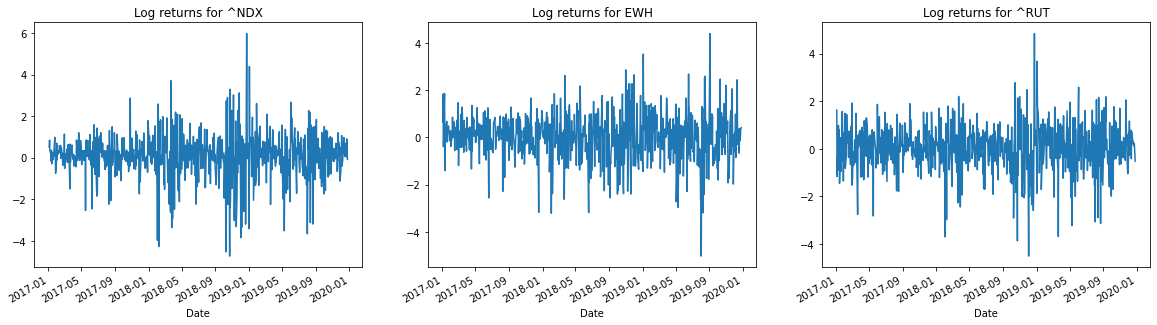

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (20,5))

train[names[0]].plot(ax = axes[0]); axes[0].set_title('Log returns for %s'% names[0])

train[names[1]].plot(ax = axes[1]); axes[1].set_title('Log returns for %s'% names[1])

train[names[2]].plot(ax = axes[2]); axes[2].set_title('Log returns for %s'% names[2])

plt.show()

In [9]:
print(train.mean(), train.var(), sep = '\n')

^NDX    0.077218
EWH     0.027050
^RUT    0.026728
dtype: float64
^NDX    1.182526
EWH     0.963314
^RUT    0.965648
dtype: float64


C:\Users\lkdes\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


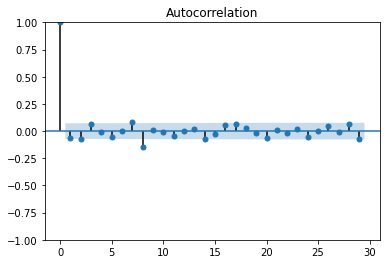

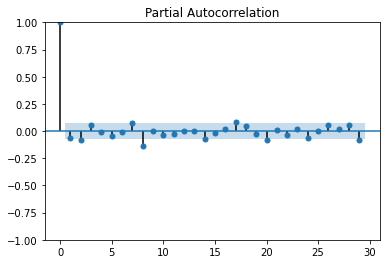

C:\Users\lkdes\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


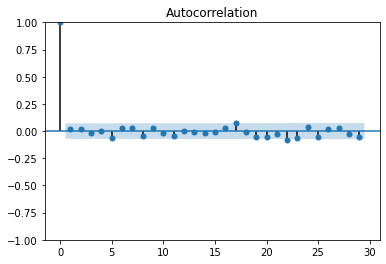

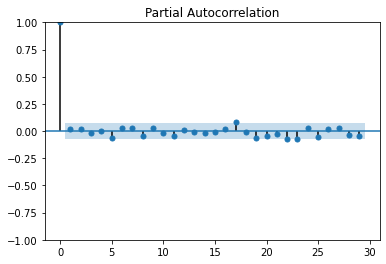

C:\Users\lkdes\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


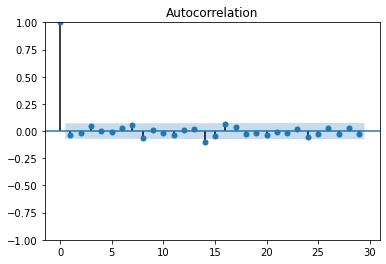

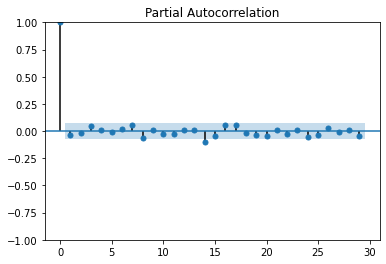

ADF Statistic for ^NDX: -10.813654
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic for EWH: -26.887926
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic for ^RUT: -28.309714
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [8]:
for i in train:
    plot_acf(train[str(i)])
    plot_pacf(train[str(i)])
    plt.show()
for i in train:
    adf_check = adfuller(train[str(i)])
    print('ADF Statistic for %s: %f' % (str(i), adf_check[0]))
    print('p-value: %f' % adf_check[1])
    print('Critical Values:')
    for key, value in adf_check[4].items():
        print('\t%s: %.3f' % (key, value))

In [11]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=3
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train, variables = train.columns) 

,^NDX_x,EWH_x,^RUT_x
^NDX_y,1.0000,0.0126,0.2781
EWH_y,0.0514,1.0000,0.0005
^RUT_y,0.3031,0.0650,1.0000


# Подбор VARMA

In [12]:
from pmdarima import auto_arima
pq = []
for name, column in train.iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : ^NDX
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2261.542, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2261.934, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2261.012, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2260.557, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2259.657, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2255.314, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2252.810, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2255.653, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2254.028, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2254.059, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2260.496, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2260.231, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2255.948, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2250.512, Time=0.30

In [ ]:
models = []
for i in range (2, 8):
    for j in range(0, 3):
        model = VARMAX(train, order=(i,j)).fit( disp=False)
        models.append([model, i, j])

In [ ]:
better_mse = 1000
better_aic = 10000
ans_aic = []
ans_mse = []
for j in models: 
    mse = j[0].mse
    aic = j[0].aic
    if mse < better_mse:
        better_mse = mse
        ans_mse = j
    if (aic < better_aic ):
        better_aic = aic
        ans_aic = j
print(ans_aiq, ans_mse)

In [9]:
varma_model_5 = VARMAX(train, order=(7,1)).fit( disp=False)

C:\Users\lkdes\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\lkdes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lkdes\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
varma_model_5.summary()

Dep. Variable:,"['^NDX', 'EWH', '^RUT']",No. Observations:,751
Model:,"VARMA(7,1)",Log Likelihood,-2641.820
,+ intercept,AIC,5445.639
Date:,"Tue, 17 May 2022",BIC,5819.973
Time:,09:25:17,HQIC,5589.869
Sample:,0,,
,- 751,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.00, 0.00",Jarque-Bera (JB):,"411.64, 82.90, 3.48"
Prob(Q):,"0.98, 0.95, 0.97",Prob(JB):,"0.00, 0.00, 0.18"
Heteroskedasticity (H):,"2.23, 2.31, 0.87",Skew:,"-0.53, -0.33, 0.00"


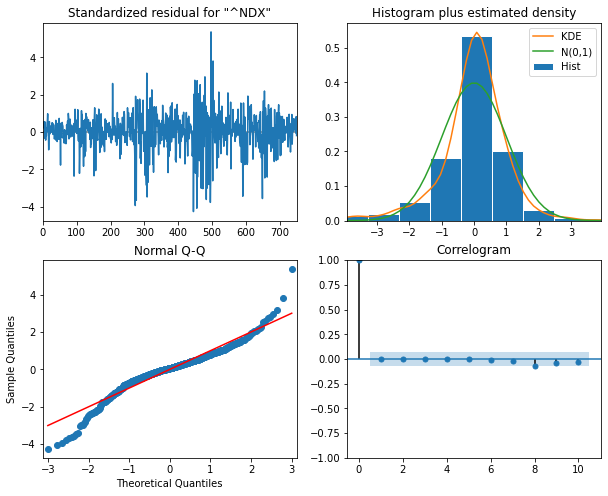

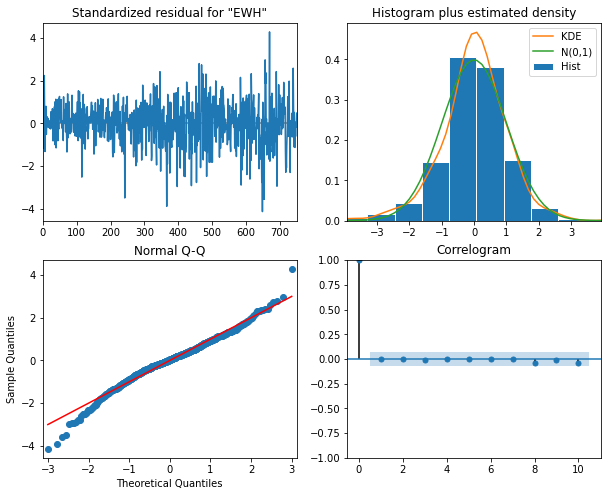

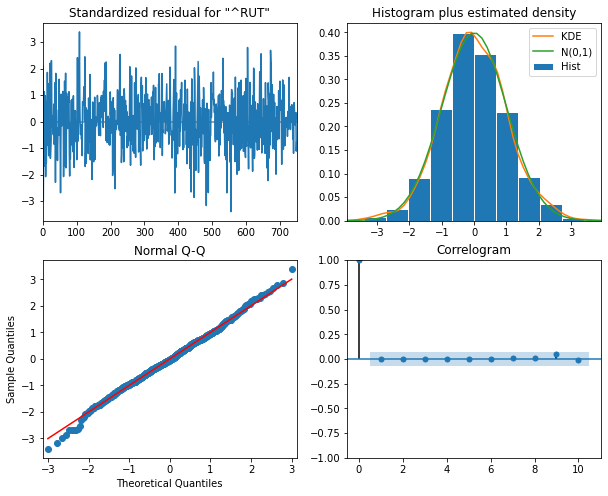

In [14]:
for i in names:
    varma_model_5.plot_diagnostics(i, figsize =(10,8))

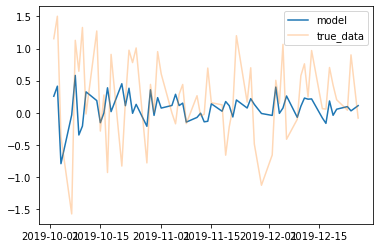

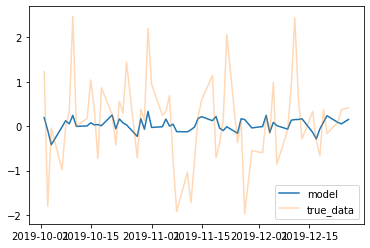

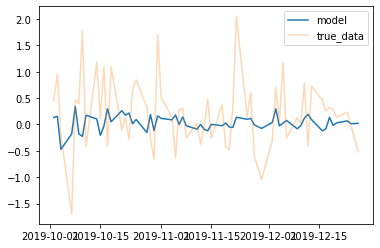

In [15]:
for i in names:
    plt.plot(varma_model_5.fittedvalues[i][-60:], label = 'model')
    plt.plot(train[i][-60:], label = 'true_data', alpha = 0.3)
    plt.legend()
    plt.show()

In [16]:
for i in names:
    timeseries_evaluation_metrics_func(train[i], varma_model_5.fittedvalues[i])

Evaluation metric results:-
MSE is : 1.103863730837421
MAE is : 0.7308436989508298
RMSE is : 1.05064919494445
WAPE is : 97.67670885728033
Evaluation metric results:-
MSE is : 0.9250223069763149
MAE is : 0.7139316460625841
RMSE is : 0.9617807998584267
WAPE is : 98.18054250250484
Evaluation metric results:-
MSE is : 0.9378267877157322
MAE is : 0.7202716791217233
RMSE is : 0.968414574299526
WAPE is : 99.46460538860954


In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox
for i in names:
    ljung_res = acorr_ljungbox(varma_model_5.resid[i], lags= 15, boxpierce=True)
    ljung_res.to_excel('%s_.xlsx'%i, header=True, index=False, encoding='utf-8')
    print(ljung_res)

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.000476   0.982596   0.000474   0.982630
2    0.000825   0.999588   0.000821   0.999590
3    0.018996   0.999308   0.018872   0.999314
4    0.019337   0.999954   0.019210   0.999954
5    0.028915   0.999993   0.028699   0.999993
6    0.201940   0.999841   0.199885   0.999846
7    0.395902   0.999745   0.391529   0.999755
8    3.997521   0.857347   3.945318   0.862023
9    5.139955   0.821941   5.071063   0.828070
10   5.688355   0.840732   5.610724   0.846840
11   6.053115   0.869797   5.969186   0.875412
12   6.135949   0.909074   6.050480   0.913516
13   6.173055   0.939627   6.086847   0.942935
14  10.654469   0.712942  10.473038   0.726846
15  10.679103   0.774993  10.497116   0.787361
     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1   0.000011   0.997353  0.000011   0.997358
2   0.007365   0.996324  0.007325   0.996344
3   0.007926   0.999813  0.007883   0.999814
4   0.009808   0.999988  0.009750   0.999988
5   0.089722   0.999876

In [10]:
step = 1
varma_result_5 = varma_model_5.get_forecast(steps = step, index = test.index)

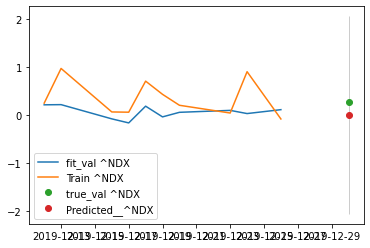

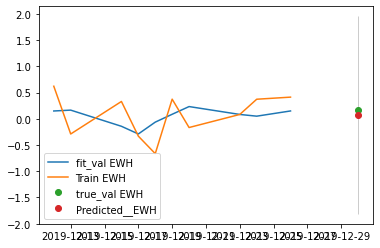

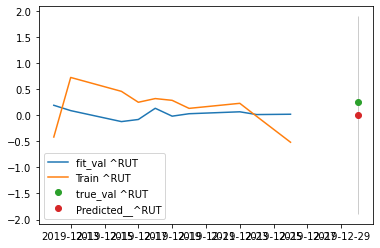

In [11]:
import matplotlib.pyplot as plt
#%matplotlib inline
for i in varma_result_5.predicted_mean:
    plt.plot(varma_model_5.fittedvalues[str(i)][-10:], label='fit_val '+str(i))
    plt.plot(train[str(i)][-10:], label='Train '+str(i))
    plt.plot(test[str(i)], 'o', label='true_val '+str(i))
    plt.plot(varma_result_5.predicted_mean[str(i)],'o', label='Predicted__'+str(i))
    plt.fill_between(test.index, varma_result_5.conf_int(0.95)['lower ' + str(i)],
                         varma_result_5.conf_int(0.95)['upper ' + str(i)], color = 'k', alpha = 0.2)
    plt.legend(loc='lower left')
    plt.show()

In [19]:
for i in names:
    timeseries_evaluation_metrics_func(test[i], varma_result_5.predicted_mean[i])

Evaluation metric results:-
MSE is : 0.07300657311355084
MAE is : 0.2701972855406783
RMSE is : 0.2701972855406783
WAPE is : 100.96457073573688
Evaluation metric results:-
MSE is : 0.008745922930669937
MAE is : 0.09351963927790749
RMSE is : 0.09351963927790749
WAPE is : 56.83795825706125
Evaluation metric results:-
MSE is : 0.06458804019258937
MAE is : 0.25414177183727465
RMSE is : 0.25414177183727465
WAPE is : 98.02870445222044


In [23]:
varma_result_5.conf_int(0.95)

,lower ^NDX,lower EWH,lower ^RUT,upper ^NDX,upper EWH,upper ^RUT
Date,,,,,,
2019-12-30,-2.061777,-1.813203,-1.892556,2.056614,1.955239,1.902777


# Подбор GARCH

In [24]:
resid5 = varma_model_5.resid
for i in resid5:
    res = het_arch(resid5[str(i)],  nlags=20)
    print('Lagrange multiplier test statistic for %s %f '% (str(i), res[0]))
    print('p-value for Lagrange multiplier test ',res[1])
    print('fstatistic for F test ',res[2])
    print('pvalue for F test ',res[3])

Lagrange multiplier test statistic for ^NDX 138.368248 
p-value for Lagrange multiplier test  1.0315663573902095e-19
fstatistic for F test  8.288575145229533
pvalue for F test  4.344827948411416e-22
Lagrange multiplier test statistic for EWH 64.167445 
p-value for Lagrange multiplier test  1.5828716285148824e-06
fstatistic for F test  3.416066424723906
pvalue for F test  7.933380687647037e-07
Lagrange multiplier test statistic for ^RUT 95.375647 
p-value for Lagrange multiplier test  8.389293912629596e-12
fstatistic for F test  5.326786878357741
pvalue for F test  1.023931214487817e-12


In [25]:
varma5_g_models = {}
for i in names:
    varma5_g_models[i] = arch_model(resid5[i], p = 1, q = 1, dist='ged').fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 34458.18391785222
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3281649.5826920406
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1106.4607966386475
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1235.5165372321949
Iteration:      5,   Func. Count:     41,   Neg. LLF: 991.7026850817931
Iteration:      6,   Func. Count:     48,   Neg. LLF: 981.7343125961331
Iteration:      7,   Func. Count:     55,   Neg. LLF: 971.1784573722464
Iteration:      8,   Func. Count:     62,   Neg. LLF: 970.7796389998958
Iteration:      9,   Func. Count:     68,   Neg. LLF: 970.7606657395106
Iteration:     10,   Func. Count:     74,   Neg. LLF: 970.7597917211557
Iteration:     11,   Func. Count:     80,   Neg. LLF: 970.759583025899
Iteration:     12,   Func. Count:     86,   Neg. LLF: 970.7595691482784
Iteration:     13,   Func. Count:     91,   Neg. LLF: 970.7595691483006
Optimization terminated successfully    (Exit mode 0)
        

In [35]:
varma5_g_models[names[2]].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                            
==========================================================================================
Dep. Variable:                               ^RUT   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -986.224
Distribution:      Generalized Error Distribution   AIC:                           1982.45
Method:                        Maximum Likelihood   BIC:                           2005.55
                                                    No. Observations:                  751
Date:                            Tue, May 17 2022   Df Residuals:                      750
Time:                                    09:28:59   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0477  2.928e-02      1.627      0.104 [-9.736e-03,  0.105]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0328  1.487e-02      2.202  2.764e-02 [3.604e-03,6.190e-02]
alpha[1]       0.0908  2.662e-02      3.412  6.452e-04   [3.864e-02,  0.143]
beta[1]        0.8736  3.243e-02     26.941 7.286e-160     [  0.810,  0.937]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.4574      0.103     14.210  7.908e-46 [  1.256,  1.658]
========================================================================

Covariance estimator: robust
"""

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox
for i in names:
    st_res = varma5_g_models[i].resid/varma5_g_models[i].conditional_volatility
    ljung_res = acorr_ljungbox(st_res, lags= 9, boxpierce=True)
    ljung_res.to_excel('%s_.xlsx'%i, header=True, index=False, encoding='utf-8')
    print(ljung_res)

    lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  0.463465   0.496009  0.461619   0.496868
2  1.909747   0.384861  1.900218   0.386699
3  1.914767   0.590284  1.905205   0.592313
4  2.027160   0.730763  2.016701   0.732687
5  2.032818   0.844586  2.022307   0.846050
6  4.008122   0.675577  3.976625   0.679840
7  5.499510   0.599243  5.450188   0.605199
8  5.900233   0.658406  5.845589   0.664523
9  8.904580   0.446129  8.806048   0.455367
    lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  0.004055   0.949224  0.004039   0.949325
2  0.450607   0.798274  0.448219   0.799228
3  1.808281   0.613134  1.796878   0.615615
4  2.062832   0.724203  2.049400   0.726673
5  2.564883   0.766693  2.546784   0.769433
6  2.643682   0.852054  2.624746   0.854254
7  3.343997   0.851462  3.316691   0.854243
8  4.227881   0.836000  4.188837   0.839697
9  4.260947   0.893414  4.221419   0.896244
    lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  0.259752   0.610291  0.258717   0.611003
2  0.260339   0.877947  0.259301

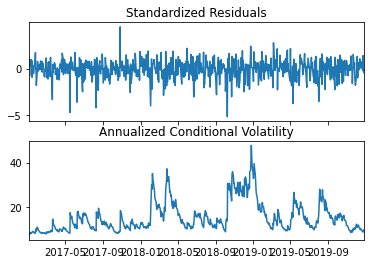

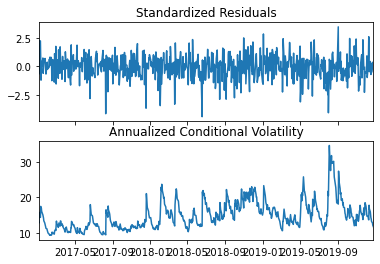

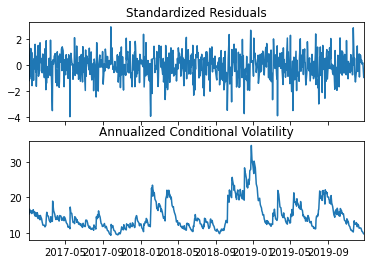

In [27]:
for i in names:
    varma5_g_models[i].plot(annualize="D")
    plt.show()

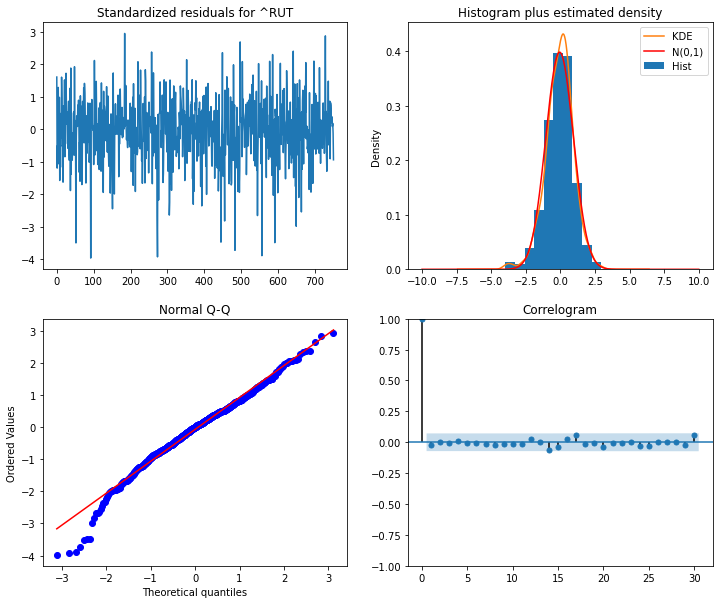

In [86]:
import numpy as np 
import pylab 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import norm
import statistics

fig, axes = plt.subplots(2, 2, figsize = (12,10))

for i in names[2:]:
    st_res = varma5_g_models[i].resid/varma5_g_models[i].conditional_volatility
    mean = statistics.mean(st_res)
    sd = statistics.stdev(st_res)
    x_axis = np.arange(-10, 10, 0.01)
    axes[0,0].plot(st_res.values); axes[0,0].set_title('Standardized residuals for %s'%i)
    stats.probplot(st_res, dist="norm", plot=axes[1,0])
    plot_acf(st_res,lags =30, ax = axes[1,1])
    axes[0,1].hist(st_res, density = True, label='Hist')
    st_res.plot.kde(ax = axes[0,1], label='KDE')
    axes[0,1].plot(x_axis, norm.pdf(x_axis, mean, sd), color='red', label  = 'N(0,1)')
    axes[0,1].legend()
    axes[0,1].set_title('Histogram plus estimated density')
    axes[1,0].set_title('Normal Q-Q')
    axes[1,1].set_title('Correlogram')
    plt.show()

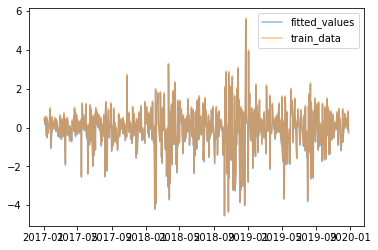

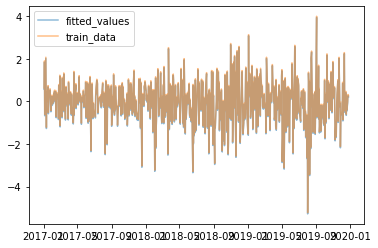

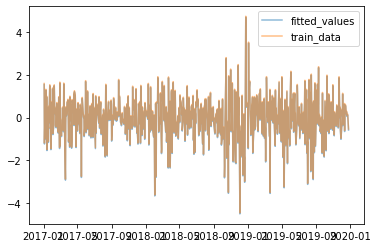

In [28]:
for i in names:
    plt.plot(varma5_g_models[i].resid , alpha = 0.5, label='fitted_values')
    plt.plot(resid5[i],alpha = 0.5, label='train_data')
    plt.legend()
    plt.show()

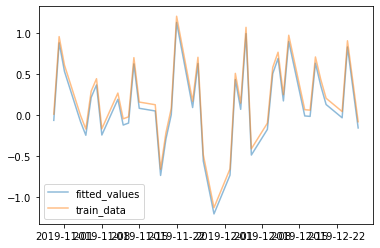

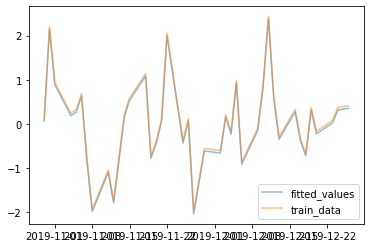

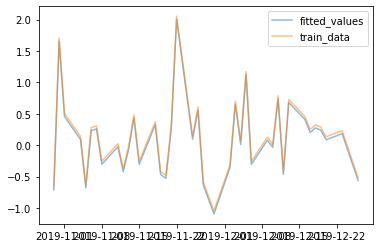

In [36]:
for i in names:
    plt.plot(varma_model_5.fittedvalues[str(i)][-40:] + varma5_g_models[i].resid[-40:] , alpha = 0.5, label='fitted_values')
    plt.plot(train[i][-40:],alpha = 0.5, label='train_data')
    plt.legend()
    plt.show()

In [37]:
for i in names:
    timeseries_evaluation_metrics_func(train[i], varma_model_5.fittedvalues[str(i)] + varma5_g_models[i].resid)

Evaluation metric results:-
MSE is : 0.005770682629807682
MAE is : 0.07596500924641347
RMSE is : 0.07596500924641346
WAPE is : 10.152666161252276
Evaluation metric results:-
MSE is : 0.003177582830412425
MAE is : 0.056370052602533784
RMSE is : 0.05637005260253378
WAPE is : 7.752061945894391
Evaluation metric results:-
MSE is : 0.0022707767348720785
MAE is : 0.04765266765745732
RMSE is : 0.047652667657457314
WAPE is : 6.580508329916645


In [38]:
vr5_g_forecast = {}
for i in names:
    pred = varma5_g_models[i].forecast(horizon = 1, start = (2019,12,28), reindex = False)
    vr5_g_forecast[i] = pd.DataFrame({'var': pred.variance.values[-1,:],'mean':pred.mean.values[-1,:],
                                 'resid': np.sqrt(pred.residual_variance.values[-1,:])}, index = test.index)

In [39]:
vr5_g_mean = {}
vr5_g_variance = []
for i in names:
    vr5_g_mean[i] = varma_result_5.predicted_mean[i] + vr5_g_forecast[i]['mean']
    vr5_g_variance.append(vr5_g_forecast[i]['var'].values[0])
vr5_g_mean = pd.DataFrame(vr5_g_mean)

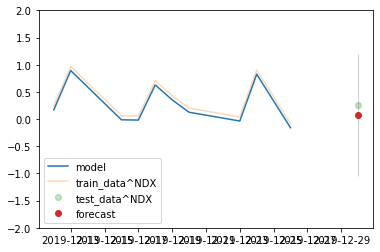

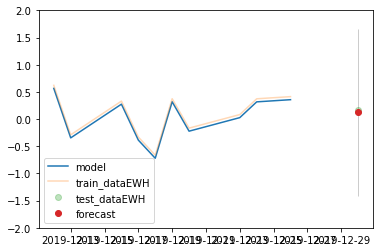

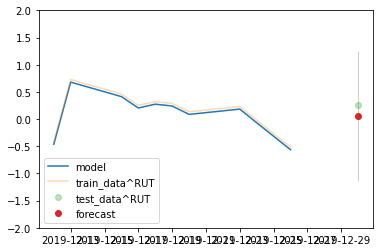

In [40]:
for i in names:
    plt.ylim([-2, 2])
    plt.plot(varma_model_5.fittedvalues[i][-10:] + varma5_g_models[i].resid[-10:], label = 'model')
    plt.plot(train[i][-10:], label = 'train_data'+i, alpha = 0.3)
    plt.plot(test[i], 'o', label = 'test_data' + i, alpha = 0.3)
    plt.plot(vr5_g_mean[i], 'o', label = 'forecast')
    plt.fill_between(test.index, vr5_g_mean[i]- 3*vr5_g_forecast[i]['var'].values[0],
                         vr5_g_mean[i]+ 3*vr5_g_forecast[i]['var'].values[0], color = 'k', alpha = 0.2)
    plt.legend(loc='lower left')
    plt.show()

In [42]:
for i in names:
    print(vr5_g_mean[i]- 3*vr5_g_forecast[i]['var'].values[0],
                         vr5_g_mean[i]+ 3*vr5_g_forecast[i]['var'].values[0], '\n')

Date
2019-12-30   -1.050747
Name: ^NDX, dtype: float64 Date
2019-12-30    1.197515
Name: ^NDX, dtype: float64 

Date
2019-12-30   -1.408995
Name: EWH, dtype: float64 Date
2019-12-30    1.663771
Name: EWH, dtype: float64 

Date
2019-12-30   -1.142539
Name: ^RUT, dtype: float64 Date
2019-12-30    1.248066
Name: ^RUT, dtype: float64 



In [41]:
for i in names:
    timeseries_evaluation_metrics_func(test[i], vr5_g_mean[i])

Evaluation metric results:-
MSE is : 0.03772617715445164
MAE is : 0.19423227629426484
RMSE is : 0.19423227629426484
WAPE is : 72.57873949338071
Evaluation metric results:-
MSE is : 0.001380091790151102
MAE is : 0.037149586675373686
RMSE is : 0.037149586675373686
WAPE is : 22.578216436948747
Evaluation metric results:-
MSE is : 0.042637750144983465
MAE is : 0.20648910417981736
RMSE is : 0.20648910417981736
WAPE is : 79.64790368742611


# Подсчет ковариации методом CCC и оптимальный портфель

In [32]:
vr_garch_correlation = [train.corr().iloc[0,1], train.corr().iloc[0,2], train.corr().iloc[1,2]]
vr5_g_cov = ccc_cov(vr5_g_variance, vr_garch_correlation)

In [33]:
vr5_gp_min_var, vr5_gp_decided_mean_level, vr5_g_mu, vr5_g_var = portfolio_search(vr5_g_mean, vr5_g_cov, 0.09)

In [34]:
print("Портфель минимального риска {s[0]}: {p[0]}, {s[1]}: {p[1]}, {s[2]}: {p[2]}".format(s = names, p = vr5_gp_min_var[0]))
print("Доходность: {p[0]}, дисперсия: {p[1]}".format(p = vr5_gp_min_var[1:]) )
print("Портфель уровня доходности {s[0]}: {p[0]}, {s[1]}: {p[1]}, {s[2]}: {p[2]}"
      .format(s = names, p = vr5_gp_decided_mean_level[0]))
print("Доходность: {p[0]}, дисперсия: {p[1]}".format(p = vr5_gp_decided_mean_level[1:]) )

Портфель минимального риска ^NDX: 0.41000000000000003, EWH: 0.26, ^RUT: 0.32999999999999996
Доходность: 0.08061999517311783, дисперсия: 0.3222285558711288
Портфель уровня доходности ^NDX: 0.4, EWH: 0.39, ^RUT: 0.20999999999999996
Доходность: 0.09011496481754959, дисперсия: 0.3288879192936548


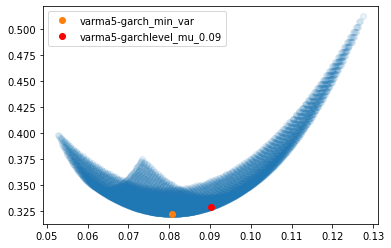

In [35]:
plot_portfolios(vr5_gp_min_var, vr5_gp_decided_mean_level, vr5_g_mu, vr5_g_var, 'varma5-garch')

# Подсчет портфеля DCC 

In [36]:
dcc_cov = [[0.4167986, 0.2345029, 0.2611668],
[0.2345029, 0.5004058, 0.1727962],
[0.2611668, 0.1727962, 0.4159049]]

In [37]:
vr5_dcc_g_min_var, vr5_dcc_g_decided_mean, vr5_dcc_g_mu, vr5_dcc_g_var  = portfolio_search(vr5_g_mean, dcc_cov, 0.09)

In [38]:
print("Портфель минимального риска {s[0]}: {p[0]}, {s[1]}: {p[1]}, {s[2]}: {p[2]}".format(s = names, p = vr5_dcc_g_min_var[0]))
print("Доходность: {p[0]}, дисперсия: {p[1]}".format(p = vr5_dcc_g_min_var[1:]) )
print("Портфель уровня доходности {s[0]}: {p[0]}, {s[1]}: {p[1]}, {s[2]}: {p[2]}"
      .format(s = names, p = vr5_dcc_g_decided_mean[0]))
print("Доходность: {p[0]}, дисперсия: {p[1]}".format(p = vr5_dcc_g_decided_mean[1:]) )

Портфель минимального риска ^NDX: 0.28, EWH: 0.32, ^RUT: 0.39999999999999997
Доходность: 0.08241681226203897, дисперсия: 0.29522345824
Портфель уровня доходности ^NDX: 0.25, EWH: 0.43, ^RUT: 0.32
Доходность: 0.09000688639727678, дисперсия: 0.30092193242


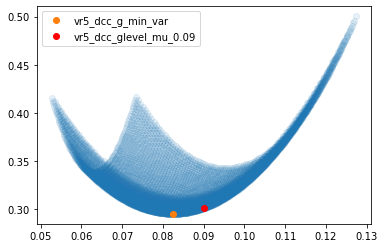

In [39]:
plot_portfolios(vr5_dcc_g_min_var, vr5_dcc_g_decided_mean, vr5_dcc_g_mu, vr5_dcc_g_var, 'vr5_dcc_g')

#  Оптимальные портфель Марковица, VaR, CVaR

In [46]:
alpha = 0.95
T = np.linspace(0, 1, 201)
ans_var = -10
var_x = [0]*len(names)
ans_cvar = -10
cvar_x = [0]*len(names)
res_var = []
res_cvar = []
for x in T:
    for p in T:
        if x + p<=1:
            portfolio = x*train.iloc[:, 0] + p*train.iloc[:, 1]+ (1-x-p)*train.iloc[:, 2]
            VaR = calc_var(portfolio, alpha)
            if VaR >= ans_var:
                ans_var = VaR
                var_x = [x, p, 1-x-p]
            CVaR = np.mean(portfolio[portfolio < VaR])
            if CVaR >= ans_cvar:
                ans_cvar = CVaR
                cvar_x = [x, p, 1-x-p]

In [41]:
print("Оптимальный портфель VaR {s[0]}: {p[0]}, {s[1]}: {p[1]}, {s[2]}: {p[2]}".format(s = names, p = var_x))
print("Критерий VaR: ", ans_var )
print("Оптимальный портфель CVaR {s[0]}: {p[0]}, {s[1]}: {p[1]}, {s[2]}: {p[2]}"
      .format(s = names, p = cvar_x))
print("Критерий CVaR: ", ans_cvar )

Оптимальный портфель VaR ^NDX: 0.0, EWH: 0.615, ^RUT: 0.385
Критерий VaR:  -1.5070424122026136
Оптимальный портфель CVaR ^NDX: 0.0, EWH: 0.5700000000000001, ^RUT: 0.42999999999999994
Критерий CVaR:  -2.073506490900581


In [48]:
p_var_variance = portf_variance(var_x, train.cov())
p_var_mean = portf_mean(var_x, train.mean())
p_cvar_variance =portf_variance(cvar_x, train.cov())
p_cvar_mean = portf_mean(cvar_x, train.mean())
print("Мат ожидание и дисперсия оптимального по VaR портфеля ", p_var_mean, p_var_variance)
print("Мат ожидание и дисперсия оптимального по CVaR портфеля", p_cvar_mean, p_cvar_variance)

Мат ожидание и дисперсия оптимального по VaR портфеля  0.026926257800964262 0.7618624648390011
Мат ожидание и дисперсия оптимального по CVaR портфеля 0.026911770867052695 0.7548528951771118


In [49]:
t = np.linspace(0, 1, 101)
p_variance = []
p_mean = []
min_var = 100
min_mean = 0
min_portf = [0]*len(names)
for x in t:
    for p in t:
        if x+p<=1:
            mean = portf_mean([x, p, 1-x-p], train.mean())
            p_mean.append(mean)
            var = portf_variance([x, p, 1-x-p], train.cov())
            p_variance.append(var)
            if var < min_var:
                min_var = var
                min_mean = mean
                min_portf = [x, p, 1-x-p]

In [44]:
print('Минимальный портфель: %f - %s, %f - %s, %f - %s' 
      %(min_portf[0], names[0], min_portf[1], names[1], min_portf[2], names[2]))
print('Вариация: ', min_var, ' среднее значение ', min_mean)

Минимальный портфель: 0.030000 - ^NDX, 0.490000 - EWH, 0.480000 - ^RUT
Вариация:  0.7504655195880428  среднее значение  0.02840069473023141


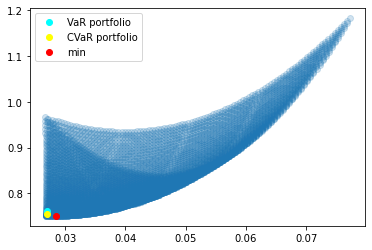

In [45]:
plt.plot(p_mean, p_variance, 'o', alpha= 0.2)
plt.plot(p_var_mean, p_var_variance, 'o', color='cyan', label = "VaR portfolio", )
plt.plot(p_cvar_mean, p_cvar_variance,'o', color='yellow', label = "CVaR portfolio")
plt.plot(min_mean, min_var,'o', color='red', label = "min")
plt.legend()
plt.show()

In [149]:
ver_mean = test
cov_eval = pd.concat(get_data(names,datetime(2020,1,1), datetime(2020,12,7)), axis= 1)
ver_cov = cov_eval.cov()

In [143]:
ver_mean = train.mean()
ver_cov = train.cov()

In [150]:
t = np.linspace(0, 1, 101)
verify_p_variance = []
verify_p_mean = []
for x in t:
    for p in t:
        if x+p<=1:
            mean = portf_mean([x, p, 1-x-p], ver_mean)
            verify_p_mean.append(mean)
            var = portf_variance([x, p, 1-x-p], ver_cov)
            verify_p_variance.append(var)

In [151]:
var_portf = [portf_mean(var_x, ver_mean), portf_variance(var_x, ver_cov)]
cvar_portf = [portf_mean(cvar_x, ver_mean), portf_variance(cvar_x, ver_cov)]
min_variance_portf = [portf_mean(min_portf, ver_mean), portf_variance(min_portf, ver_cov)]
#garch_min_variance_p = [portf_mean(gp_min_var[0], ver_mean), portf_variance(gp_min_var[0], ver_cov)]
#garch_level_mean_p = [portf_mean(gp_decided_mean_level[0], ver_mean), portf_variance(gp_decided_mean_level[0], ver_cov)]
vr5_g_min_variance_p = [portf_mean(vr5_gp_min_var[0], ver_mean), portf_variance(vr5_gp_min_var[0], ver_cov)]
vr5_g_level_mean_p = [portf_mean(vr5_gp_decided_mean_level[0], ver_mean), portf_variance(vr5_gp_decided_mean_level[0], ver_cov)]
vr5_dcc_g_min_variance_p = [portf_mean(vr5_dcc_g_min_var[0], ver_mean), portf_variance(vr5_dcc_g_min_var[0], ver_cov)]
vr5_dcc_g_level_mean_p =[portf_mean(vr5_dcc_g_decided_mean[0], ver_mean), portf_variance(vr5_dcc_g_decided_mean[0], ver_cov)]

In [152]:
print(var_portf[0], cvar_portf[0], min_variance_portf[0], vr5_g_min_variance_p[0], vr5_dcc_g_min_variance_p[0])

[0.20100261] [0.20526479] [0.21309291] [0.23805553] [0.23128536]


In [153]:
print(var_x, cvar_x, min_portf, vr5_gp_min_var[0], vr5_dcc_g_min_var[0])

[0.0, 0.615, 0.385] [0.0, 0.5700000000000001, 0.42999999999999994] [0.03, 0.49, 0.48] [0.41000000000000003, 0.26, 0.32999999999999996] [0.28, 0.32, 0.39999999999999997]


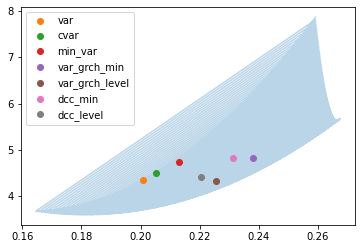

In [154]:
#plt.rcParams["figure.figsize"] = [10,7]
plt.plot(verify_p_mean, verify_p_variance, alpha = 0.3)
plt.plot(var_portf[0], var_portf[1],'o', label = 'var')
plt.plot(cvar_portf[0], cvar_portf[1],'o', label = 'cvar')
plt.plot(min_variance_portf[0], min_variance_portf[1],'o', label = 'min_var')
#plt.plot(garch_min_variance_p[0], garch_min_variance_p[1],'o', label = 'grch_min')
#plt.plot(garch_level_mean_p[0], garch_level_mean_p[1],'o', label = 'grch_level')
plt.plot(vr5_g_min_variance_p[0], vr5_g_min_variance_p[1],'o', label = 'var_grch_min')
plt.plot(vr5_g_level_mean_p[0], vr5_g_level_mean_p[1],'o', label = 'var_grch_level')
plt.plot(vr5_dcc_g_min_variance_p[0], vr5_dcc_g_min_variance_p[1],'o', label = 'dcc_min')
plt.plot(vr5_dcc_g_level_mean_p[0], vr5_dcc_g_level_mean_p[1],'o', label = 'dcc_level')
plt.legend()
plt.show()